In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import eli5
from sklearn import decomposition
import lightgbm as lgb
import xgboost as xgb

import os
from IPython.display import display_html

import json
from tqdm import tqdm_notebook

In [2]:
df_train_pickle = pd.read_pickle("./train_features_6.pkl")
df_test_pickle = pd.read_pickle("./test_features_6.pkl")

In [3]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [4]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }

In [5]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }

In [6]:
PATH_TO_DATA = '../../data/dota_2/'

df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            'train_targets.csv'), 
                                   index_col='match_id_hash')

y = df_train_targets['radiant_win'].values

Fold 0 started at Sun Nov 17 18:57:43 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.889374	valid_1's auc: 0.834787
[2000]	training's auc: 0.932525	valid_1's auc: 0.841361
[3000]	training's auc: 0.958891	valid_1's auc: 0.843257
Early stopping, best iteration is:
[3184]	training's auc: 0.962592	valid_1's auc: 0.843503
Fold 1 started at Sun Nov 17 19:05:55 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.891219	valid_1's auc: 0.823117
[2000]	training's auc: 0.933718	valid_1's auc: 0.829549
[3000]	training's auc: 0.959614	valid_1's auc: 0.831063
Early stopping, best iteration is:
[3641]	training's auc: 0.971203	valid_1's auc: 0.831368
Fold 2 started at Sun Nov 17 19:14:04 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.888925	valid_1's auc: 0.837573
[2000]	training's auc: 0.932162	valid_1's auc: 0.842847
Early stopping, best iteration is:
[2583]	training's au

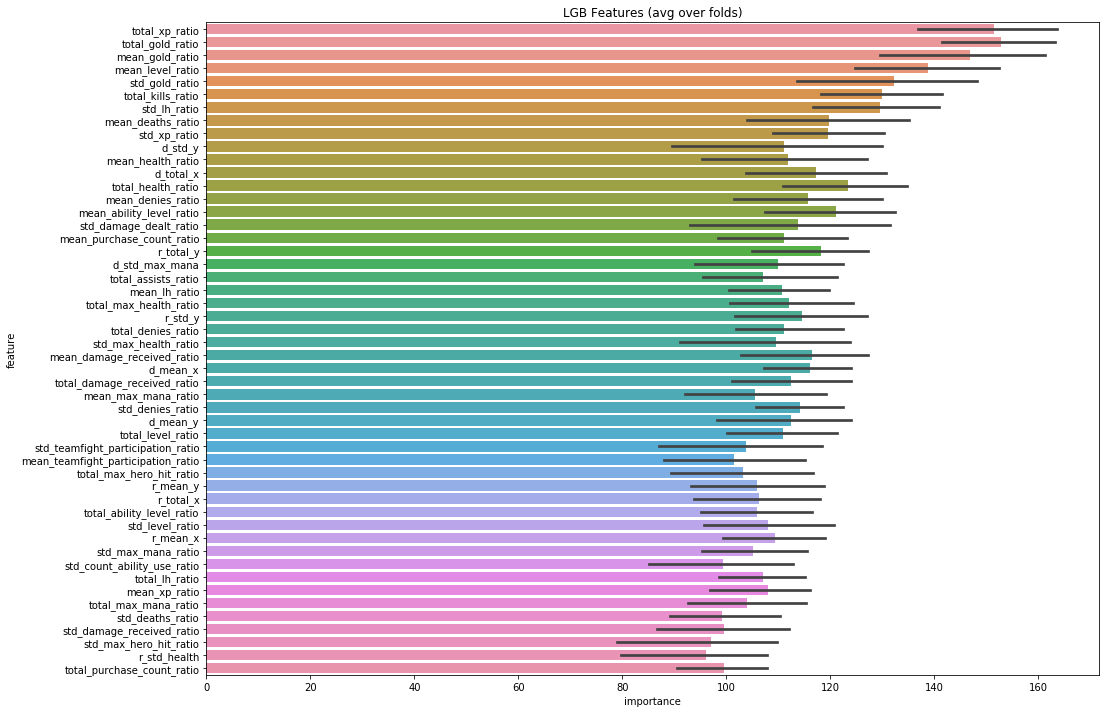

In [7]:
import time
oof_lgb, prediction_lgb, scores = train_model(df_train_pickle, df_test_pickle, y, params=params, 
                                              folds=folds, model_type='lgb', 
                                              plot_feature_importance=True)

In [8]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'test_features.csv'), 
                                    index_col='match_id_hash')

In [9]:
df_submission = pd.DataFrame(
    {'radiant_win_prob': prediction_lgb}, 
    index=df_test_features.index,)

df_submission.to_csv('sumbmission_lgb1_f6.csv')

## Let's try PCA

In [29]:
df_train_pickle.head(3)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r_total_kills,d_total_kills,total_kills_ratio,r_std_kills,d_std_kills,...,id107,id108,id109,id110,id111,id112,id113,id114,id119,id120
0,155.0,22.0,7.0,1.0,11.0,0.0,1.0,0.000000,0.00000,0.447214,...,0,0,0,0,0,0,0,0,0,0
1,658.0,4.0,0.0,3.0,10.0,16.0,3.0,5.333333,2.48998,0.547723,...,0,0,0,0,0,0,0,0,0,0
2,21.0,23.0,0.0,0.0,0.0,0.0,0.0,NaN,0.00000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.99)

In [19]:
X_train = df_train_pickle.to_numpy()

In [24]:
X = np.nan_to_num(X_train)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [25]:
np.isnan(X)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [30]:
X_train_pca = pca.fit_transform(X)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [31]:
params_xgb = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': 6,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary:logistic'
         }

In [33]:
oof_xgb, prediction_xgb, scores = train_model(df_train_pickle, df_test_pickle, y, params=params_xgb, 
                                              folds=folds, model_type='xgb', 
                                              plot_feature_importance=False)

Fold 0 started at Sun Nov 17 23:27:48 2019


ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields id001, id002, id003, id004, id005, id006, id007, id008, id009, id010, id011, id012, id013, id014, id015, id016, id017, id018, id019, id020, id021, id022, id023, id025, id026, id027, id028, id029, id030, id031, id032, id033, id034, id035, id036, id037, id038, id039, id040, id041, id042, id043, id044, id045, id046, id047, id048, id049, id050, id051, id052, id053, id054, id055, id056, id057, id058, id059, id060, id061, id062, id063, id064, id065, id066, id067, id068, id069, id070, id071, id072, id073, id074, id075, id076, id077, id078, id079, id080, id081, id082, id083, id084, id085, id086, id087, id088, id089, id090, id091, id092, id093, id094, id095, id096, id097, id098, id099, id100, id101, id102, id103, id104, id105, id106, id107, id108, id109, id110, id111, id112, id113, id114, id119, id120

In [34]:
columns = list(df_train_pickle.columns)

In [35]:
columns_to_cat = columns[-115:]
columns_to_cat

['id001',
 'id002',
 'id003',
 'id004',
 'id005',
 'id006',
 'id007',
 'id008',
 'id009',
 'id010',
 'id011',
 'id012',
 'id013',
 'id014',
 'id015',
 'id016',
 'id017',
 'id018',
 'id019',
 'id020',
 'id021',
 'id022',
 'id023',
 'id025',
 'id026',
 'id027',
 'id028',
 'id029',
 'id030',
 'id031',
 'id032',
 'id033',
 'id034',
 'id035',
 'id036',
 'id037',
 'id038',
 'id039',
 'id040',
 'id041',
 'id042',
 'id043',
 'id044',
 'id045',
 'id046',
 'id047',
 'id048',
 'id049',
 'id050',
 'id051',
 'id052',
 'id053',
 'id054',
 'id055',
 'id056',
 'id057',
 'id058',
 'id059',
 'id060',
 'id061',
 'id062',
 'id063',
 'id064',
 'id065',
 'id066',
 'id067',
 'id068',
 'id069',
 'id070',
 'id071',
 'id072',
 'id073',
 'id074',
 'id075',
 'id076',
 'id077',
 'id078',
 'id079',
 'id080',
 'id081',
 'id082',
 'id083',
 'id084',
 'id085',
 'id086',
 'id087',
 'id088',
 'id089',
 'id090',
 'id091',
 'id092',
 'id093',
 'id094',
 'id095',
 'id096',
 'id097',
 'id098',
 'id099',
 'id100',
 'id101',


In [36]:
df_train_pickle[columns_to_cat].astype('str')
df_test_pickle[columns_to_cat].astype('str');

In [37]:
np.any(np.isnan(df_train_pickle))

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [38]:
oof_cat, prediction_cat, scores = train_model(df_train_pickle, df_test_pickle, y, params=None, 
                                              folds=folds, model_type='cat', 
                                              plot_feature_importance=False)

Fold 0 started at Sun Nov 17 23:46:23 2019


NameError: name 'CatBoostClassifier' is not defined